In [ ]:

!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-cc3b25b1
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-cc3b25b1
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit e7cbea0bbd546167b9d1757b2cfeca3fbe26a33e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
# from torchnet.dataset import TensorDatasetb
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt

import segmentation_models_pytorch as smp
import torchinfo

In [ ]:


# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

GPU is available.


In [ ]:

model = smp.DeepLabV3Plus(
    encoder_name="resnet50",         # use ResNet50 as backbone
    encoder_weights="imagenet",      # use pre-trained weights from ImageNet
    encoder_depth=5,                 # number of stages used in encoder (default=5, each reduces the feature spatial dimensions by 1/2)
    encoder_output_stride=16,        # 16 for semantic segmentation suggested in the paper for best trade-off between speech and accuracy
    decoder_atrous_rates=(6,12,18),  #dilation rates for ASPP, suggested in the paper
    decoder_channels=256,            # number of convolution filters in ASPP module (default=256)
    in_channels=4,                   # number of input channels (default=3, expects RGB images)
    upsampling=4,                    # final upsampling factor (default=8, to preserve input-output spatial shape identity) 
    activation=None,                 # activation function to apply after the final convolution layer (default=None)
    classes=3,                       # output 3 channels for RGB image
    aux_params=None,                 # parameters of the auxiliary output (defualt=None)
)
model.to(device)

In [ ]:
print(torchinfo.summary(model))

Layer (type:depth-idx)                                  Param #
DeepLabV3Plus                                           --
├─ResNetEncoder: 1-1                                    --
│    └─Conv2d: 2-1                                      12,544
│    └─BatchNorm2d: 2-2                                 128
│    └─ReLU: 2-3                                        --
│    └─MaxPool2d: 2-4                                   --
│    └─Sequential: 2-5                                  --
│    │    └─Bottleneck: 3-1                             75,008
│    │    └─Bottleneck: 3-2                             70,400
│    │    └─Bottleneck: 3-3                             70,400
│    └─Sequential: 2-6                                  --
│    │    └─Bottleneck: 3-4                             379,392
│    │    └─Bottleneck: 3-5                             280,064
│    │    └─Bottleneck: 3-6                             280,064
│    │    └─Bottleneck: 3-7                             280,064
│    └─Sequent

In [ ]:
batchsize = 16
dummy_input = torch.randn(size = (batchsize,4,256,256)).to(device)

model(dummy_input).shape

torch.Size([16, 3, 256, 256])

In [ ]:
!nvidia-smi

Tue Mar 28 18:21:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    51W /  70W |   3763MiB / 15360MiB |     47%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# MODEL STORING/LOADING

In [ ]:
# storing model as decode and encoder
model_state_dict = {'encoder':model.encoder.state_dict(),'decoder':model.decoder.state_dict(),'mask':model.segmentation_head.state_dict()}
torch.save(model_state_dict,'testsave.pth')
ckpt = torch.load('testsave.pth')
model.encoder.load_state_dict(ckpt['encoder'])
model.decoder.load_state_dict(ckpt['decoder'])
model.segmentation_head.load_state_dict(ckpt['mask'])

<All keys matched successfully>

In [ ]:
del model
torch.cuda.empty_cache()

# Model Pretrain 256

In [ ]:
# prepare data
!unzip drive/MyDrive/dataset_0197/img.npy.zip
!unzip drive/MyDrive/dataset_0197/label.npy.zip
!unzip drive/MyDrive/dataset_0197/size.npy.zip

Archive:  drive/MyDrive/dataset_0197/img.npy.zip
replace img.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: img.npy                 
Archive:  drive/MyDrive/dataset_0197/label.npy.zip
replace label.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: label.npy               
Archive:  drive/MyDrive/dataset_0197/size.npy.zip
replace size.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: size.npy                


In [ ]:
test_img = np.load('img.npy')
print(test_img[0].max())# 0-255, need to normalize to 0-1
test_label = np.load('label.npy')
print(test_label[0].max())
test_size = np.load('size.npy')
print(test_size.shape)

255
2
(7390, 2)


In [ ]:
test_img.shape

(7390, 256, 256, 3)

[256 170]


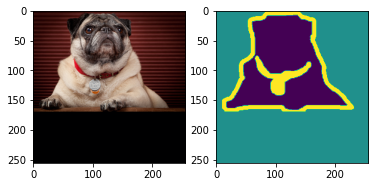

In [ ]:
_,ax = plt.subplots(nrows = 1,ncols = 2)
ax[0].imshow(test_img[1])
ax[1].imshow(test_label[1])

print(test_size[0])

3

In [ ]:
test_label.shape

(7390, 256, 256)

In [ ]:
# for speed generate mask here

mask = np.zeros_like(test_img[:,:,:,0])
for i in range(len(test_img)):
  mask[i,0:test_size[i,0],0:test_size[i,1]] = 1

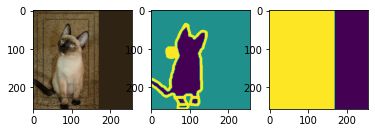

In [ ]:
_,ax = plt.subplots(nrows = 1,ncols = 3)
ax[0].imshow(test_img[3])
ax[1].imshow(test_label[3].astype(int))
ax[2].imshow(mask[0]*255.)



In [ ]:
class Pretrain_set(Dataset):
  def __init__(self, img, label, size, mask):
    super().__init__()
    self.img = torch.Tensor(img).float().permute((0,3,1,2))/255.
    self.label = torch.Tensor(label).float() #wrong but not used here
    self.size = torch.Tensor(size).float()
    self.mask = torch.Tensor(mask).float()
  def __len__(self):
    return len(self.img)

  def __getitem__(self,idx):
    return self.img[idx],self.label[idx],self.size[idx],self.mask[idx]

In [ ]:
pretrain_set = Pretrain_set(test_img,test_label,test_size,mask)

# Image Perturb

In [ ]:
def perturb(x, size, perportion = 0.5):
    """
    x: shape B*C*H*W image to perturb
    size: B*2 tensor of height and weight of the true image
    perportion: how many 
    
    This function perform masking/perturbing on the original images, used for pretraining, current method is rotation
    
    return:
    'torch.Tensor' with the same shape as input x
    """
    

    area = size[:,0]*size[:,1]
    B = area.shape[0]
    N = torch.randint(low = 8, high = 13,size = (1,))
    b = 10
    lower =  torch.floor((-3*b + np.sqrt(9*b**2-12*(b**2-3*perportion/N*area)))/b)
    # print(lower.shape)
    # print(lower)
    
    start_position = torch.rand(size = (B,N,2))
    start_position[:,:,0] *= (size[:,0].unsqueeze(1)-10)
    start_position[:,:,1] *= (size[:,1].unsqueeze(1)-10)
    start_position = torch.floor(start_position)
    
    
    length = torch.rand(size = (B,N))
    angles = torch.randint_like(length, high = 3)
    length = torch.round(lower[...,None] + length*b)
    # angle_list = torch.Tensor([90,180,270]).float()

    
    for i in range(B):
        for j in range(N):
            int_st1 = int(start_position[i,j,0])
            int_st2 = int(start_position[i,j,1])
            this_len = int(torch.round(length[i,j]))
            this_len = int(np.min([this_len, size[i,0]-int_st1,size[i,1]-int_st2]))
            patch = x[i,:,int_st1:(int_st1 + this_len),int_st2:(int_st2 + this_len)]
            # print(patch.shape)
            rotated = torch.rot90(patch, k = int(angles[i,j]), dims = [1,2])
            x[i,:,int_st1:(int_st1 + this_len),int_st2:(int_st2 + this_len)] = rotated
    
    

    return x

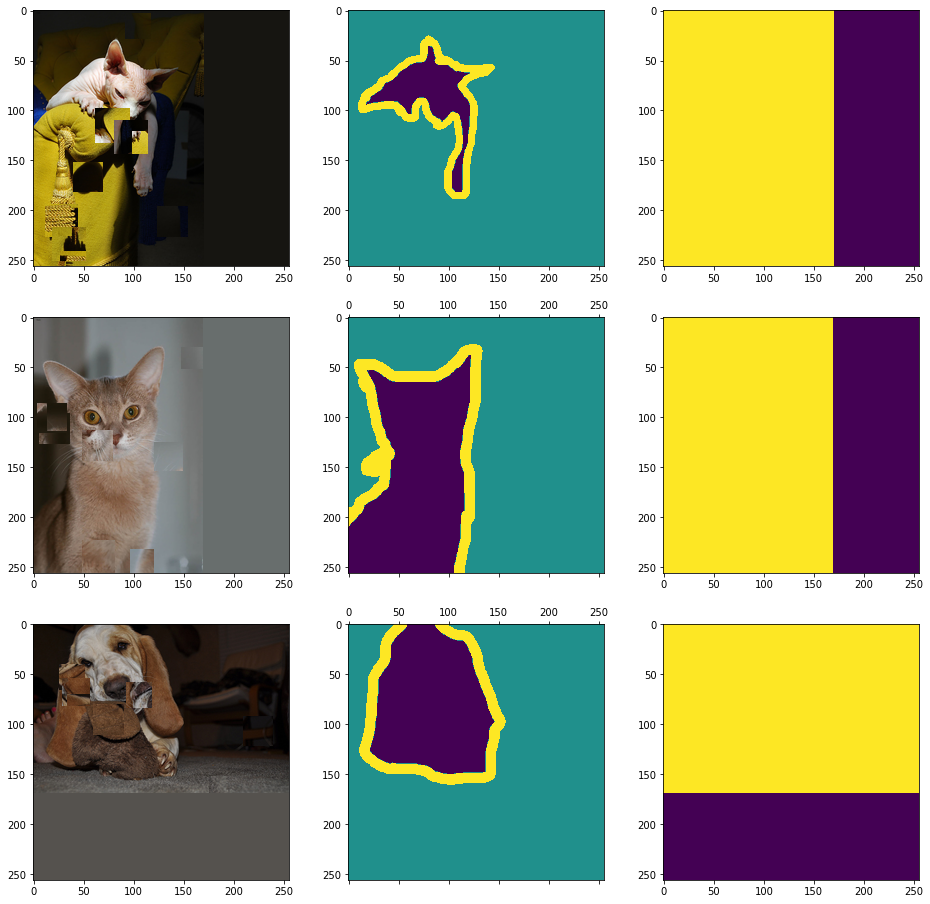

In [ ]:
# try a dataloader, and data preparing
try_batch = next(iter(DataLoader(pretrain_set,shuffle = True, batch_size = 3)))
perturbed = perturb(try_batch[0],try_batch[2]).permute((0,2,3,1))
#show perturbed images
fig,ax = plt.subplots(nrows = 3,ncols = 3,figsize =(16,16))

ax[0,0].imshow(perturbed[0])
ax[0,1].imshow(try_batch[1][0].int())
ax[0,2].imshow(try_batch[3][0])

ax[1,0].imshow(perturbed[1])
ax[1,1].matshow(try_batch[1][1].int())
ax[1,2].imshow(try_batch[3][1])

ax[2,0].imshow(perturbed[2])
ax[2,1].matshow(try_batch[1][2].int())
ax[2,2].imshow(try_batch[3][2])


# Training




In [ ]:
!pip install transformers
from transformers import get_linear_schedule_with_warmup

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pretrain_model = smp.DeepLabV3Plus(
    encoder_name="resnet50",         # use ResNet50 as backbone
    encoder_weights="imagenet",      # use pre-trained weights from ImageNet
    encoder_depth=5,                 # number of stages used in encoder (default=5, each reduces the feature spatial dimensions by 1/2)
    encoder_output_stride=16,        # 16 for semantic segmentation suggested in the paper for best trade-off between speech and accuracy
    decoder_atrous_rates=(6,12,18),  #dilation rates for ASPP, suggested in the paper
    decoder_channels=256,            # number of convolution filters in ASPP module (default=256)
    in_channels=4,                   # number of input channels (default=3, expects RGB images)
    upsampling=4,                    # final upsampling factor (default=8, to preserve input-output spatial shape identity) 
    activation=None,                 # activation function to apply after the final convolution layer (default=None)
    classes=3,                       # output 3 channels for RGB image
    aux_params=None,                 # parameters of the auxiliary output (defualt=None)
)

lr = 1e-4
optimizer = torch.optim.AdamW(pretrain_model.parameters(),lr = lr)
training_step = 20*1 # defined later
warm_up = 10
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warm_up ,num_training_steps=training_step)
batch_size = 64 # can be 128
loss_func = torch.nn.MSELoss()
save_step = 10

In [ ]:
pretrain_model.to(device)
train_loader = DataLoader(pretrain_set,shuffle = True, batch_size = batch_size)

In [ ]:
loss_list = []
step = 0

while True:

    for X in train_loader:
        pretrain_model.train()
        img, _, size, mask = X
        optimizer.zero_grad()
        # perturb image

        perturbed = perturb(img,size)
        concated = torch.concat([img,mask.unsqueeze(1)],dim = 1) # now Nx4x256x256

        img = img.to(device)
        concated = concated.to(device)
        mask = mask.unsqueeze(1).to(device)

        output = pretrain_model(concated)
        loss = torch.mean(torch.square((img-output)*mask))

        print(f"step: {step+1}, loss:{loss.item():.8f}")

        # loss_mat[i,j,k,m,step] = loss.item()
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()
        step += 1

        if step % save_step == 0:

         model_state_dict = {'encoder':pretrain_model.encoder.state_dict(),
                            'decoder':pretrain_model.decoder.state_dict(),
                            'mask':pretrain_model.segmentation_head.state_dict(),
                            'optimizer':optimizer.state_dict(),
                            'scheduler':scheduler.state_dict()}

        if step == training_step:
            break
    if step == training_step:
        break

np.save('loss.npy',np.array(loss_list))


step: 1, loss:0.29903805
step: 2, loss:0.29225028
step: 3, loss:0.31896514
step: 4, loss:0.25390142
step: 5, loss:0.22830819
step: 6, loss:0.23555848
step: 7, loss:0.18821111
step: 8, loss:0.17886770
step: 9, loss:0.15358447
step: 10, loss:0.13628435
step: 11, loss:0.13028033
step: 12, loss:0.09529865
step: 13, loss:0.08240557
step: 14, loss:0.08802956
step: 15, loss:0.06050804
step: 16, loss:0.07485703
step: 17, loss:0.06333243
step: 18, loss:0.06279024
step: 19, loss:0.05933870
step: 20, loss:0.05552006
